# Visualization Report

In [2]:
# load data from csv in drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Set current directory containing data files
DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/visualizations"

In [14]:
import os
print(os.listdir(DATA_DIR))

['performance_metrics.json', 'visualization.py', 'moderation_results.json', 'model_evaluation.png', 'deepseek', 'model_evaluation-mistral-7b.png', 'Compare_models_classification.png', 'LLM_Performance_Comparison.png', 'experiment-performance-analysis.csv']


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)
from sklearn.model_selection import cross_val_score, StratifiedKFold
from scipy import stats
import requests
import json
from datetime import datetime

def calculate_metrics(performance_metrics_path, moderation_results_path):
    """Calculates performance metrics from the provided data."""
    with open(performance_metrics_path, 'r') as f:
        performance_metrics = json.load(f)

    with open(moderation_results_path, 'r') as f:
        moderation_results = json.load(f)

    # Extract ground truth and predictions from moderation_results
    ground_truth = [item['ground_truth'] for item in moderation_results]
    predictions = [item['prediction'] for item in moderation_results]
    prediction_probabilities = [item.get('confidence', 0) for item in moderation_results] # Use .get to handle missing confidence

    # Calculate toxic-specific metrics
    toxic_ground_truth = [1 if gt == 'toxic' else 0 for gt in ground_truth]
    toxic_predictions = [1 if pred == 'toxic' else 0 for pred in predictions]

    toxic_precision = precision_score(toxic_ground_truth, toxic_predictions, zero_division=0)
    toxic_recall = recall_score(toxic_ground_truth, toxic_predictions, zero_division=0)
    toxic_f1 = f1_score(toxic_ground_truth, toxic_predictions, zero_division=0)

    # Get overall metrics from performance_metrics.json
    accuracy = performance_metrics.get('accuracy', 0)
    precision_weighted = performance_metrics.get('precision', 0) # Assuming 'precision' in json is weighted
    recall_weighted = performance_metrics.get('recall', 0) # Assuming 'recall' in json is weighted
    f1_weighted = performance_metrics.get('f1', 0) # Assuming 'f1' in json is weighted
    cm = performance_metrics.get('confusion_matrix', [[0,0],[0,0]])
    roc_auc = performance_metrics.get('roc_auc')
    accuracy_ci = (performance_metrics.get('accuracy_ci_lower', 0), performance_metrics.get('accuracy_ci_upper', 0))

    # Calculate confidence intervals for toxic metrics (simplified example, requires more data for proper calculation)
    # For a more robust calculation, you would need to perform bootstrapping or use statistical formulas
    toxic_precision_ci = (0, 0) # Placeholder
    toxic_recall_ci = (0, 0)   # Placeholder
    toxic_f1_ci = (0, 0)       # Placeholder


    metrics = {
        'accuracy': accuracy,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted,
        'toxic_precision': toxic_precision,
        'toxic_recall': toxic_recall,
        'toxic_f1': toxic_f1,
        'confusion_matrix': cm,
        'roc_auc': roc_auc,
        'sample_size': len(ground_truth),
        'accuracy_ci': accuracy_ci,
        'toxic_precision_ci': toxic_precision_ci,
        'toxic_recall_ci': toxic_recall_ci,
        'toxic_f1_ci': toxic_f1_ci,
        'ground_truth': ground_truth,
        'prediction_probabilities': prediction_probabilities,
        'processing_time': [item.get('latency') for item in moderation_results] # Use latency from moderation_results
    }
    return metrics


def create_evaluation_visualizations(metrics, output_dir):
    """Create comprehensive evaluation visualizations."""

    if not metrics:
        return

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)


    # Create comprehensive evaluation figure
    fig = plt.figure(figsize=(20, 15))

    # 1. Confusion Matrix
    ax1 = plt.subplot(3, 3, 1)
    cm = metrics['confusion_matrix']
    labels = sorted(list(set(metrics['ground_truth']))) # Use ground_truth from metrics

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=labels, yticklabels=labels, ax=ax1)
    ax1.set_title('Confusion Matrix')
    ax1.set_xlabel('Predicted Label')
    ax1.set_ylabel('True Label')

    # 2. Performance Metrics Bar Chart
    ax2 = plt.subplot(3, 3, 2)
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    metric_values = [metrics['accuracy'], metrics['precision_weighted'],
                    metrics['recall_weighted'], metrics['f1_weighted']]

    bars = ax2.bar(metric_names, metric_values, color=['blue', 'green', 'orange', 'red'], alpha=0.7)
    ax2.set_ylim(0, 1)
    ax2.set_title('Overall Performance Metrics using Mistral 7B')
    ax2.set_ylabel('Score')

    # Add value labels on bars
    for bar, value in zip(bars, metric_values):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.3f}', ha='center', va='bottom')

    # 3. Toxic Detection Specific Metrics
    ax3 = plt.subplot(3, 3, 3)
    toxic_metrics = ['Precision', 'Recall', 'F1-Score']
    toxic_values = [metrics['toxic_precision'], metrics['toxic_recall'], metrics['toxic_f1']]

    bars = ax3.bar(toxic_metrics, toxic_values, color=['red', 'orange', 'darkred'], alpha=0.7)
    ax3.set_ylim(0, 1)
    ax3.set_title('Toxic Content Detection Metrics')
    ax3.set_ylabel('Score')

    for bar, value in zip(bars, toxic_values):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.3f}', ha='center', va='bottom')

    # 4. ROC Curve (if available)
    if metrics['roc_auc'] is not None and len(set([1 if label == "toxic" else 0 for label in metrics['ground_truth']])) > 1: # Use ground_truth from metrics
        ax4 = plt.subplot(3, 3, 4)
        y_true_binary = [1 if label == "toxic" else 0 for label in metrics['ground_truth']] # Use ground_truth from metrics
        fpr, tpr, _ = roc_curve(y_true_binary, metrics['prediction_probabilities']) # Use prediction_probabilities from metrics

        ax4.plot(fpr, tpr, color='darkorange', lw=2,
                label=f'ROC curve (AUC = {metrics["roc_auc"]:.3f})')
        ax4.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax4.set_xlim([0.0, 1.0])
        ax4.set_ylim([0.0, 1.05])
        ax4.set_xlabel('False Positive Rate')
        ax4.set_ylabel('True Positive Rate')
        ax4.set_title('ROC Curve')
        ax4.legend(loc="lower right")
    else:
        ax4 = plt.subplot(3, 3, 4)
        ax4.text(0.5, 0.5, "ROC Curve Not Available", horizontalalignment='center', verticalalignment='center', fontsize=12)
        ax4.axis('off')


    # 5. Precision-Recall Curve
    ax5 = plt.subplot(3, 3, 5)
    if len(set([1 if label == "toxic" else 0 for label in metrics['ground_truth']])) > 1: # Use ground_truth from metrics
        y_true_binary = [1 if label == "toxic" else 0 for label in metrics['ground_truth']] # Use ground_truth from metrics
        precision_curve, recall_curve, _ = precision_recall_curve(y_true_binary, metrics['prediction_probabilities']) # Use prediction_probabilities from metrics
        avg_precision = average_precision_score(y_true_binary, metrics['prediction_probabilities']) # Use prediction_probabilities from metrics

        ax5.plot(recall_curve, precision_curve, color='blue', lw=2,
                label=f'AP = {avg_precision:.3f}')
        ax5.set_xlabel('Recall')
        ax5.set_ylabel('Precision')
        ax5.set_title('Precision-Recall Curve')
        ax5.legend()
    else:
        ax5 = plt.subplot(3, 3, 5)
        ax5.text(0.5, 0.5, "Precision-Recall Curve Not Available", horizontalalignment='center', verticalalignment='center', fontsize=12)
        ax5.axis('off')


    # 6. Confidence Distribution
    ax6 = plt.subplot(3, 3, 6)
    if metrics['prediction_probabilities']:
        ax6.hist(metrics['prediction_probabilities'], bins=20, alpha=0.7, color='skyblue', edgecolor='black') # Use prediction_probabilities from metrics
        ax6.set_xlabel('Prediction Confidence')
        ax6.set_ylabel('Frequency')
        ax6.set_title('Prediction Confidence Distribution')
        ax6.axvline(np.mean(metrics['prediction_probabilities']), color='red', linestyle='--', # Use prediction_probabilities from metrics
                   label=f'Mean: {np.mean(metrics["prediction_probabilities"]):.3f}')
        ax6.legend()
    else:
        ax6 = plt.subplot(3, 3, 6)
        ax6.text(0.5, 0.5, "Confidence Distribution Not Available", horizontalalignment='center', verticalalignment='center', fontsize=12)
        ax6.axis('off')


    # 7. Processing Time Analysis
    ax7 = plt.subplot(3, 3, 7)
    processing_times = [t for t in metrics['processing_time'] if t is not None] # Use processing_time from metrics and filter None values
    if processing_times:
        ax7.hist(processing_times, bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
        ax7.set_xlabel('Processing Time (ms)')
        ax7.set_ylabel('Frequency')
        ax7.set_title('Processing Time Distribution')
        ax7.axvline(np.mean(processing_times), color='red', linestyle='--',
                   label=f'Mean: {np.mean(processing_times):.1f}ms')
        ax7.legend()
    else:
        ax7 = plt.subplot(3, 3, 7)
        ax7.text(0.5, 0.5, "Processing Time Data Not Available", horizontalalignment='center', verticalalignment='center', fontsize=12)
        ax7.axis('off')

    # 8. Performance Summary Table
    ax8 = plt.subplot(3, 3, 8)
    ax8.axis('tight')
    ax8.axis('off')

    summary_data = [
        ['Metric', 'Value', '95% CI'],
        ['Accuracy', f'{metrics["accuracy"]:.3f}',
         f'({metrics.get("accuracy_ci", (0,0))[0]:.3f}, {metrics.get("accuracy_ci", (0,0))[1]:.3f})'],
        ['Toxic Precision', f'{metrics["toxic_precision"]:.3f}',
         f'({metrics.get("toxic_precision_ci", (0,0))[0]:.3f}, {metrics.get("toxic_precision_ci", (0,0))[1]:.3f})'],
        ['Toxic Recall', f'{metrics["toxic_recall"]:.3f}',
         f'({metrics.get("toxic_recall_ci", (0,0))[0]:.3f}, {metrics.get("toxic_recall_ci", (0,0))[1]:.3f})'],
        ['Toxic F1-Score', f'{metrics["toxic_f1"]:.3f}',
         f'({metrics.get("toxic_f1_ci", (0,0))[0]:.3f}, {metrics.get("toxic_f1_ci", (0,0))[1]:.3f})'],
        ['Sample Size', f'{metrics["sample_size"]}', 'N/A']
    ]

    table = ax8.table(cellText=summary_data, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)
    ax8.set_title('Performance Summary with Confidence Intervals')

    # 9. Label Distribution
    ax9 = plt.subplot(3, 3, 9)
    if metrics['ground_truth']:
        label_counts = pd.Series(metrics['ground_truth']).value_counts() # Use ground_truth from metrics
        ax9.pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%')
        ax9.set_title('Ground Truth Label Distribution')
    else:
        ax9 = plt.subplot(3, 3, 9)
        ax9.text(0.5, 0.5, "Label Distribution Not Available", horizontalalignment='center', verticalalignment='center', fontsize=12)
        ax9.axis('off')


    plt.tight_layout()
    plt.savefig(f'{output_dir}/model_evaluation-mistral-7b.png', dpi=300, bbox_inches='tight')
    plt.close()

    return metrics

# generate report
if __name__ == "__main__":
    performance_metrics_path = os.path.join(DATA_DIR, 'performance_metrics.json')
    moderation_results_path = os.path.join(DATA_DIR, 'moderation_results.json')

    # Calculate metrics
    evaluation_metrics = calculate_metrics(performance_metrics_path, moderation_results_path)

    # Create visualizations
    create_evaluation_visualizations(evaluation_metrics, DATA_DIR)

    print("Report generated successfully for mistral 7b.")

Report generated successfully.


In [ ]:
# Set current directory containing data files
DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/visualizations/deepseek"

In [ ]:
import os
print(os.listdir(DATA_DIR))

['performance_metrics.json', 'moderation_results.json', 'model_evaluation.png', 'model_evaluation-deepseek-r1.png']


In [ ]:
"""

Generate report

"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)
from sklearn.model_selection import cross_val_score, StratifiedKFold
from scipy import stats
import requests
import json
from datetime import datetime

def calculate_metrics(performance_metrics_path, moderation_results_path):
    """Calculates performance metrics from the provided data."""
    with open(performance_metrics_path, 'r') as f:
        performance_metrics = json.load(f)

    with open(moderation_results_path, 'r') as f:
        moderation_results = json.load(f)

    # Extract ground truth and predictions from moderation_results
    ground_truth = [item['ground_truth'] for item in moderation_results]
    predictions = [item['prediction'] for item in moderation_results]
    prediction_probabilities = [item.get('confidence', 0) for item in moderation_results] # Use .get to handle missing confidence

    # Calculate toxic-specific metrics
    toxic_ground_truth = [1 if gt == 'toxic' else 0 for gt in ground_truth]
    toxic_predictions = [1 if pred == 'toxic' else 0 for pred in predictions]

    toxic_precision = precision_score(toxic_ground_truth, toxic_predictions, zero_division=0)
    toxic_recall = recall_score(toxic_ground_truth, toxic_predictions, zero_division=0)
    toxic_f1 = f1_score(toxic_ground_truth, toxic_predictions, zero_division=0)

    # Get overall metrics from performance_metrics.json
    accuracy = performance_metrics.get('accuracy', 0)
    precision_weighted = performance_metrics.get('precision', 0) # Assuming 'precision' in json is weighted
    recall_weighted = performance_metrics.get('recall', 0) # Assuming 'recall' in json is weighted
    f1_weighted = performance_metrics.get('f1', 0) # Assuming 'f1' in json is weighted
    cm = performance_metrics.get('confusion_matrix', [[0,0],[0,0]])
    roc_auc = performance_metrics.get('roc_auc')
    accuracy_ci = (performance_metrics.get('accuracy_ci_lower', 0), performance_metrics.get('accuracy_ci_upper', 0))

    # Calculate confidence intervals for toxic metrics (simplified example, requires more data for proper calculation)
    # For a more robust calculation, you would need to perform bootstrapping or use statistical formulas
    toxic_precision_ci = (0, 0) # Placeholder
    toxic_recall_ci = (0, 0)   # Placeholder
    toxic_f1_ci = (0, 0)       # Placeholder


    metrics = {
        'accuracy': accuracy,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted,
        'toxic_precision': toxic_precision,
        'toxic_recall': toxic_recall,
        'toxic_f1': toxic_f1,
        'confusion_matrix': cm,
        'roc_auc': roc_auc,
        'sample_size': len(ground_truth),
        'accuracy_ci': accuracy_ci,
        'toxic_precision_ci': toxic_precision_ci,
        'toxic_recall_ci': toxic_recall_ci,
        'toxic_f1_ci': toxic_f1_ci,
        'ground_truth': ground_truth,
        'prediction_probabilities': prediction_probabilities,
        'processing_time': [item.get('latency') for item in moderation_results] # Use latency from moderation_results
    }
    return metrics


def create_evaluation_visualizations(metrics, output_dir):
    """Create comprehensive evaluation visualizations."""

    if not metrics:
        return

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)


    # Create comprehensive evaluation figure
    fig = plt.figure(figsize=(20, 15))

    # 1. Confusion Matrix
    ax1 = plt.subplot(3, 3, 1)
    cm = metrics['confusion_matrix']
    labels = sorted(list(set(metrics['ground_truth']))) # Use ground_truth from metrics

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=labels, yticklabels=labels, ax=ax1)
    ax1.set_title('Confusion Matrix')
    ax1.set_xlabel('Predicted Label')
    ax1.set_ylabel('True Label')

    # 2. Performance Metrics Bar Chart
    ax2 = plt.subplot(3, 3, 2)
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    metric_values = [metrics['accuracy'], metrics['precision_weighted'],
                    metrics['recall_weighted'], metrics['f1_weighted']]

    bars = ax2.bar(metric_names, metric_values, color=['blue', 'green', 'orange', 'red'], alpha=0.7)
    ax2.set_ylim(0, 1)
    ax2.set_title('Overall Performance Metrics using DeepSeek-R1')
    ax2.set_ylabel('Score')

    # Add value labels on bars
    for bar, value in zip(bars, metric_values):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.3f}', ha='center', va='bottom')

    # 3. Toxic Detection Specific Metrics
    ax3 = plt.subplot(3, 3, 3)
    toxic_metrics = ['Precision', 'Recall', 'F1-Score']
    toxic_values = [metrics['toxic_precision'], metrics['toxic_recall'], metrics['toxic_f1']]

    bars = ax3.bar(toxic_metrics, toxic_values, color=['red', 'orange', 'darkred'], alpha=0.7)
    ax3.set_ylim(0, 1)
    ax3.set_title('Toxic Content Detection Metrics')
    ax3.set_ylabel('Score')

    for bar, value in zip(bars, toxic_values):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.3f}', ha='center', va='bottom')

    # 4. ROC Curve (if available)
    if metrics['roc_auc'] is not None and len(set([1 if label == "toxic" else 0 for label in metrics['ground_truth']])) > 1: # Use ground_truth from metrics
        ax4 = plt.subplot(3, 3, 4)
        y_true_binary = [1 if label == "toxic" else 0 for label in metrics['ground_truth']] # Use ground_truth from metrics
        fpr, tpr, _ = roc_curve(y_true_binary, metrics['prediction_probabilities']) # Use prediction_probabilities from metrics

        ax4.plot(fpr, tpr, color='darkorange', lw=2,
                label=f'ROC curve (AUC = {metrics["roc_auc"]:.3f})')
        ax4.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax4.set_xlim([0.0, 1.0])
        ax4.set_ylim([0.0, 1.05])
        ax4.set_xlabel('False Positive Rate')
        ax4.set_ylabel('True Positive Rate')
        ax4.set_title('ROC Curve')
        ax4.legend(loc="lower right")
    else:
        ax4 = plt.subplot(3, 3, 4)
        ax4.text(0.5, 0.5, "ROC Curve Not Available", horizontalalignment='center', verticalalignment='center', fontsize=12)
        ax4.axis('off')


    # 5. Precision-Recall Curve
    ax5 = plt.subplot(3, 3, 5)
    if len(set([1 if label == "toxic" else 0 for label in metrics['ground_truth']])) > 1: # Use ground_truth from metrics
        y_true_binary = [1 if label == "toxic" else 0 for label in metrics['ground_truth']] # Use ground_truth from metrics
        precision_curve, recall_curve, _ = precision_recall_curve(y_true_binary, metrics['prediction_probabilities']) # Use prediction_probabilities from metrics
        avg_precision = average_precision_score(y_true_binary, metrics['prediction_probabilities']) # Use prediction_probabilities from metrics

        ax5.plot(recall_curve, precision_curve, color='blue', lw=2,
                label=f'AP = {avg_precision:.3f}')
        ax5.set_xlabel('Recall')
        ax5.set_ylabel('Precision')
        ax5.set_title('Precision-Recall Curve')
        ax5.legend()
    else:
        ax5 = plt.subplot(3, 3, 5)
        ax5.text(0.5, 0.5, "Precision-Recall Curve Not Available", horizontalalignment='center', verticalalignment='center', fontsize=12)
        ax5.axis('off')


    # 6. Confidence Distribution
    ax6 = plt.subplot(3, 3, 6)
    if metrics['prediction_probabilities']:
        ax6.hist(metrics['prediction_probabilities'], bins=20, alpha=0.7, color='skyblue', edgecolor='black') # Use prediction_probabilities from metrics
        ax6.set_xlabel('Prediction Confidence')
        ax6.set_ylabel('Frequency')
        ax6.set_title('Prediction Confidence Distribution')
        ax6.axvline(np.mean(metrics['prediction_probabilities']), color='red', linestyle='--', # Use prediction_probabilities from metrics
                   label=f'Mean: {np.mean(metrics["prediction_probabilities"]):.3f}')
        ax6.legend()
    else:
        ax6 = plt.subplot(3, 3, 6)
        ax6.text(0.5, 0.5, "Confidence Distribution Not Available", horizontalalignment='center', verticalalignment='center', fontsize=12)
        ax6.axis('off')


    # 7. Processing Time Analysis
    ax7 = plt.subplot(3, 3, 7)
    processing_times = [t for t in metrics['processing_time'] if t is not None] # Use processing_time from metrics and filter None values
    if processing_times:
        ax7.hist(processing_times, bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
        ax7.set_xlabel('Processing Time (ms)')
        ax7.set_ylabel('Frequency')
        ax7.set_title('Processing Time Distribution')
        ax7.axvline(np.mean(processing_times), color='red', linestyle='--',
                   label=f'Mean: {np.mean(processing_times):.1f}ms')
        ax7.legend()
    else:
        ax7 = plt.subplot(3, 3, 7)
        ax7.text(0.5, 0.5, "Processing Time Data Not Available", horizontalalignment='center', verticalalignment='center', fontsize=12)
        ax7.axis('off')

    # 8. Performance Summary Table
    ax8 = plt.subplot(3, 3, 8)
    ax8.axis('tight')
    ax8.axis('off')

    summary_data = [
        ['Metric', 'Value', '95% CI'],
        ['Accuracy', f'{metrics["accuracy"]:.3f}',
         f'({metrics.get("accuracy_ci", (0,0))[0]:.3f}, {metrics.get("accuracy_ci", (0,0))[1]:.3f})'],
        ['Toxic Precision', f'{metrics["toxic_precision"]:.3f}',
         f'({metrics.get("toxic_precision_ci", (0,0))[0]:.3f}, {metrics.get("toxic_precision_ci", (0,0))[1]:.3f})'],
        ['Toxic Recall', f'{metrics["toxic_recall"]:.3f}',
         f'({metrics.get("toxic_recall_ci", (0,0))[0]:.3f}, {metrics.get("toxic_recall_ci", (0,0))[1]:.3f})'],
        ['Toxic F1-Score', f'{metrics["toxic_f1"]:.3f}',
         f'({metrics.get("toxic_f1_ci", (0,0))[0]:.3f}, {metrics.get("toxic_f1_ci", (0,0))[1]:.3f})'],
        ['Sample Size', f'{metrics["sample_size"]}', 'N/A']
    ]

    table = ax8.table(cellText=summary_data, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)
    ax8.set_title('Performance Summary with Confidence Intervals')

    # 9. Label Distribution
    ax9 = plt.subplot(3, 3, 9)
    if metrics['ground_truth']:
        label_counts = pd.Series(metrics['ground_truth']).value_counts() # Use ground_truth from metrics
        ax9.pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%')
        ax9.set_title('Ground Truth Label Distribution')
    else:
        ax9 = plt.subplot(3, 3, 9)
        ax9.text(0.5, 0.5, "Label Distribution Not Available", horizontalalignment='center', verticalalignment='center', fontsize=12)
        ax9.axis('off')


    plt.tight_layout()
    plt.savefig(f'{output_dir}/model_evaluation-deepseek-r1.png', dpi=300, bbox_inches='tight')
    plt.close()

    return metrics

# generate report
if __name__ == "__main__":
    performance_metrics_path = os.path.join(DATA_DIR, 'performance_metrics.json')
    moderation_results_path = os.path.join(DATA_DIR, 'moderation_results.json')

    # Calculate metrics
    evaluation_metrics = calculate_metrics(performance_metrics_path, moderation_results_path)

    # Create visualizations
    create_evaluation_visualizations(evaluation_metrics, DATA_DIR)

    print("Report generated successfully for DeepSeek LLM.")

Report generated successfully for DeepSeek LLM.


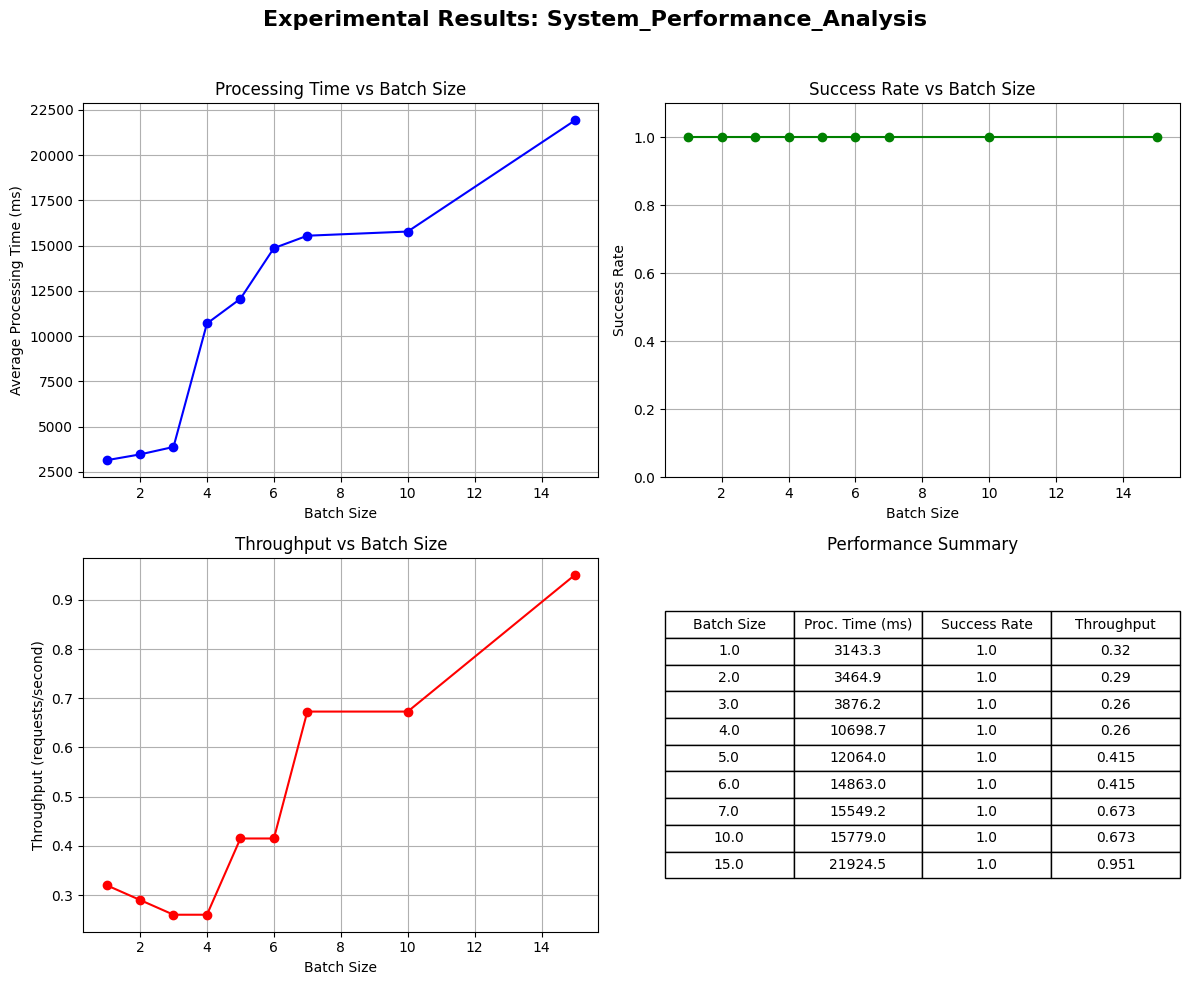

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Data
data = {
    'Batch Size': [1, 2, 3, 4, 5, 6, 7, 10, 15],
    'Proc. Time (ms)': [3143.3, 3464.9, 3876.2, 10698.7, 12064.0, 14863.0, 15549.2, 15779.0, 21924.5],
    'Success Rate': [1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000],
    'Throughput': [0.32, 0.29, 0.26, 0.26, 0.415, 0.415, 0.673, 0.673, 0.951]
}

df = pd.DataFrame(data)

# Create figure and subplots
fig = plt.figure(figsize=(12, 10))
fig.suptitle('Experimental Results: System_Performance_Analysis', fontsize=16, fontweight='bold')

# Plot 1: Processing Time vs Batch Size
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax1.plot(df['Batch Size'], df['Proc. Time (ms)'], marker='o', color='blue')
ax1.set_title('Processing Time vs Batch Size')
ax1.set_xlabel('Batch Size')
ax1.set_ylabel('Average Processing Time (ms)')
ax1.grid(True)

# Plot 2: Success Rate vs Batch Size
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax2.plot(df['Batch Size'], df['Success Rate'], marker='o', color='green')
ax2.set_title('Success Rate vs Batch Size')
ax2.set_xlabel('Batch Size')
ax2.set_ylabel('Success Rate')
ax2.set_ylim(0, 1.1)
ax2.grid(True)

# Plot 3: Throughput vs Batch Size
ax3 = plt.subplot2grid((2, 2), (1, 0))
ax3.plot(df['Batch Size'], df['Throughput'], marker='o', color='red')
ax3.set_title('Throughput vs Batch Size')
ax3.set_xlabel('Batch Size')
ax3.set_ylabel('Throughput (requests/second)')
ax3.grid(True)

# Table
ax4 = plt.subplot2grid((2, 2), (1, 1))
ax4.axis('off')
table = ax4.table(
    cellText=df.values,
    colLabels=df.columns,
    loc='center',
    cellLoc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)
ax4.set_title('Performance Summary')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save or show
plt.savefig('System_Performance_Analysis_Report.png', dpi=300)
plt.savefig(f'{DATA_DIR}/model_evaluation-deepseek-r1.png', dpi=300, bbox_inches='tight')
plt.show()


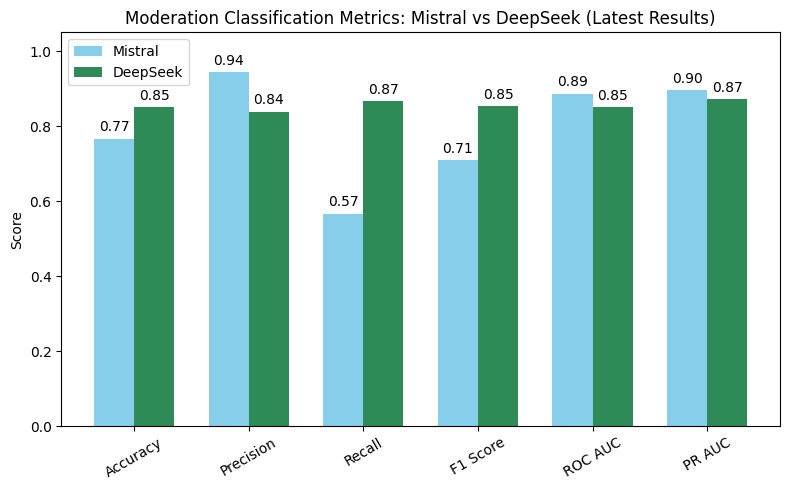

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Latest results
metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC", "PR AUC"]
deepseek_values = [0.8500, 0.8387, 0.8667, 0.8525, 0.8500, 0.8729]
mistral_values = [0.7667, 0.9444, 0.5667, 0.7083, 0.8867, 0.8966]

x = np.arange(len(metrics))  # label locations
width = 0.35  # bar width

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, mistral_values, width, label='Mistral', color='skyblue')
bars2 = ax.bar(x + width/2, deepseek_values, width, label='DeepSeek', color='seagreen')

# Labels and title
ax.set_ylabel('Score')
ax.set_title('Moderation Classification Metrics: Mistral vs DeepSeek (Latest Results)')
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=30)
ax.set_ylim(0, 1.05)
ax.legend()

# Annotate bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()

# Save or show
plt.savefig('Compare_models.png', dpi=300)
plt.savefig(f'{DATA_DIR}/Compare_models_classification.png', dpi=300, bbox_inches='tight')
plt.show()


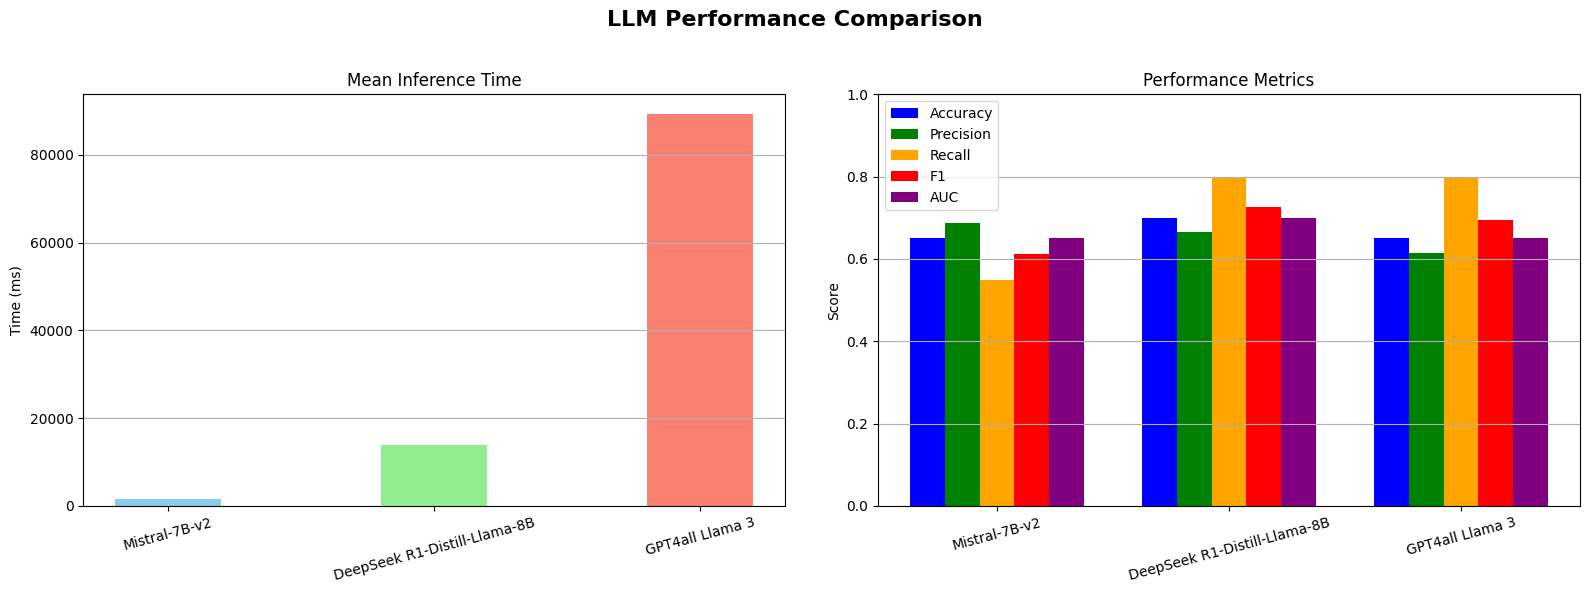

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data for different models
data = {
    'Model': ['Mistral-7B-v2', 'DeepSeek R1-Distill-Llama-8B', 'GPT4all Llama 3'],
    'Mean inference time (ms)': [1597.95, 13946.95, 89335.39],
    'Accuracy': [0.6500, 0.7000, 0.6500],
    'Precision': [0.6875, 0.6667, 0.6154],
    'Recall': [0.5500, 0.8000, 0.8000],
    'F1': [0.6111, 0.7273, 0.6957],
    'AUC': [0.6500, 0.7000, 0.6500]
}

df = pd.DataFrame(data)

# Create figure and subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(16, 6)) # Adjusted figure size

fig.suptitle('LLM Performance Comparison', fontsize=16, fontweight='bold')

# Plot 1: Mean inference time
ax1 = axes[0]
colors = ['skyblue', 'lightgreen', 'salmon']
ax1.bar(df['Model'], df['Mean inference time (ms)'], color=colors, width=0.4) # Reduced bar width
ax1.set_title('Mean Inference Time')
ax1.set_ylabel('Time (ms)')
ax1.tick_params(axis='x', rotation=15)
ax1.grid(axis='y')

# Plot 2: Performance Metrics
ax2 = axes[1]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
bar_colors = ['blue', 'green', 'orange', 'red', 'purple'] # Colors for each metric

# Plot bars for each model and metric
bar_width = 0.15
x = np.arange(len(df['Model']))

for i, metric in enumerate(metrics):
    ax2.bar(x + i * bar_width - (len(metrics) / 2 - 0.5) * bar_width,
            df[metric], bar_width, label=metric, color=bar_colors[i])

ax2.set_title('Performance Metrics')
ax2.set_ylabel('Score')
ax2.set_xticks(x)
ax2.set_xticklabels(df['Model'], rotation=15)
ax2.set_ylim(0, 1.0)
ax2.legend()
ax2.grid(axis='y')


plt.tight_layout(rect=[0, 0, 1, 0.96], w_pad=3.0) # Increased horizontal spacing

# Save or show
plt.savefig(f'{DATA_DIR}/LLM_Performance_Comparison.png', dpi=300)
plt.show()

Successfully loaded data from: /content/drive/MyDrive/Colab Notebooks/visualizations/experiment-performance-analysis.csv


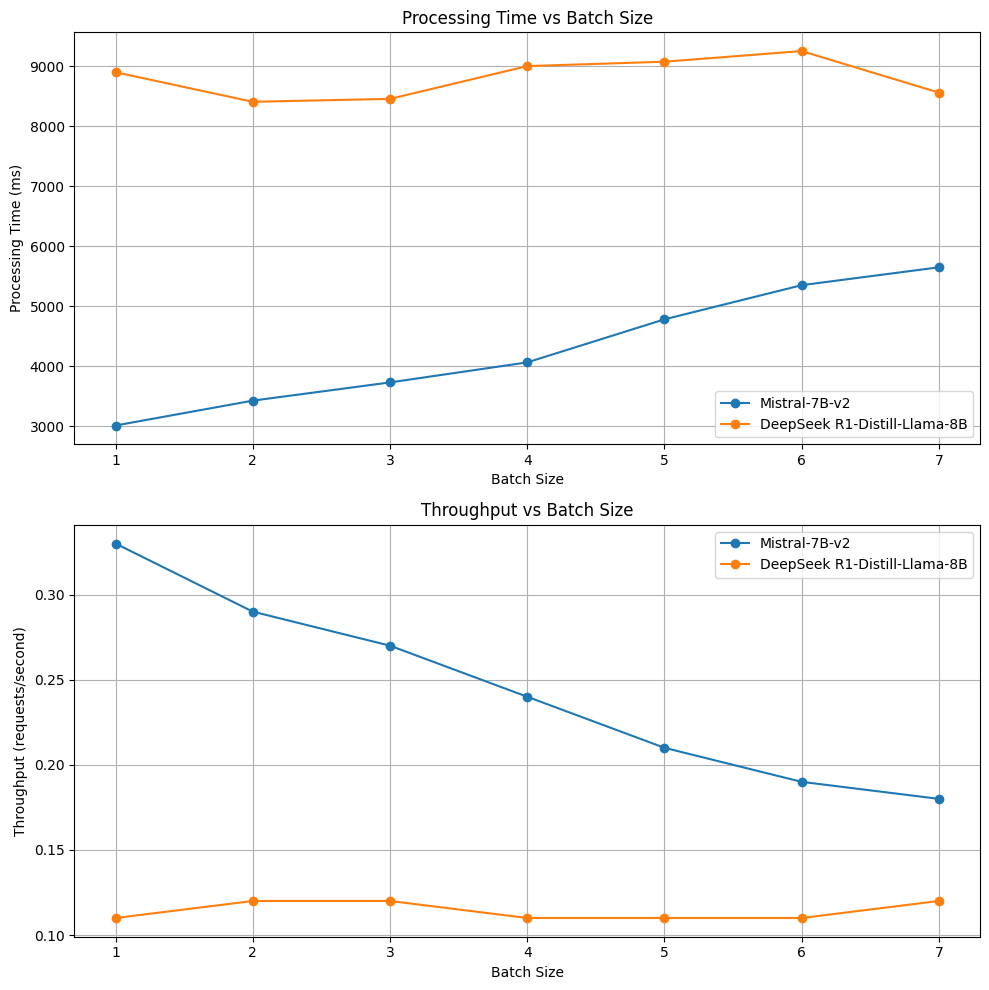

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Load CSV
csv_path = os.path.join(DATA_DIR, "experiment-performance-analysis.csv")
df = pd.read_csv(csv_path)
print(f"Successfully loaded data from: {csv_path}") # Add a print statement to confirm loading

# Separate Mistral and DeepSeek data
# Use the correct column names provided by the user
batch_sizes = df["Batch Size"]
mistral_proc_time = df["Mistral-7B-v2 – Proc. Time (ms)"]
mistral_throughput = df["Mistral-7B-v2 – Throughput"]

deepseek_proc_time = df["DeepSeek R1-Distill-Llama-8B – Proc. Time (ms)"]
deepseek_throughput = df["DeepSeek – Throughput"]

# Create figure and subplots with 1 column and 2 rows
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Plot Processing Time vs Batch Size on the first subplot
axes[0].plot(batch_sizes, mistral_proc_time, marker='o', label="Mistral-7B-v2")
axes[0].plot(batch_sizes, deepseek_proc_time, marker='o', label="DeepSeek R1-Distill-Llama-8B")
axes[0].set_xlabel("Batch Size")
axes[0].set_ylabel("Processing Time (ms)")
axes[0].set_title("Processing Time vs Batch Size")
axes[0].legend()
axes[0].grid(True)

# Plot Throughput vs Batch Size on the second subplot
axes[1].plot(batch_sizes, mistral_throughput, marker='o', label="Mistral-7B-v2")
axes[1].plot(batch_sizes, deepseek_throughput, marker='o', label="DeepSeek R1-Distill-Llama-8B")
axes[1].set_xlabel("Batch Size")
axes[1].set_ylabel("Throughput (requests/second)")
axes[1].set_title("Throughput vs Batch Size")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()

# Save or show
plt.savefig(f'{DATA_DIR}/experiment-performance-analysis.png', dpi=300)
plt.show()